In [1]:
%load_ext autoreload

import os
import sys
sys.path.append('../../..')
import numpy as np
from tqdm import tqdm_notebook as tqdm
from scipy.interpolate import interp1d, interp2d

import config
import main
import pickle
import darkhistory.physics as phys
import darkhistory.history.tla as tla
from darkhistory.spec.spectra import Spectra
from darkhistory.spec.spectrum import Spectrum
import darkhistory.low_energy.atomic as atomic
import darkhistory.spec.spectools as spectools
from plotting_utils import plot_distortion, download_plot

import matplotlib
matplotlib.rc_file('../../matplotlibrc')
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib.colors as colors
%matplotlib inline

In [2]:
### SETTINGS TO CHANGE
output_dir = '/Users/viviesque/OneDrive - Massachusetts Institute of Technology/DarkHistory/output/'
fig_dir = '/Users/viviesque/OneDrive - Massachusetts Institute of Technology/DarkHistory/figs/'

# Scan over parameters, or load previous data

In [3]:
# CMB constraints on interaction rates
input_dir = config.data_path

f_elec_CMB_raw = np.loadtxt(input_dir+'/CMB_limits_elec_swave.dat', delimiter=',')
log10eng_elec_CMB  = f_elec_CMB_raw[0:2760:69, 0]
log10rs_elec_CMB = f_elec_CMB_raw[0:69, 1]

f_phot_CMB_raw = np.loadtxt(input_dir+'/CMB_limits_phot_swave.dat', delimiter=',')
log10eng_phot_CMB  = f_phot_CMB_raw[0:2800:70, 0]
log10rs_phot_CMB = f_phot_CMB_raw[0:70, 1]

f_elec_CMB_raw = np.transpose(np.reshape(f_elec_CMB_raw[:,2], (40,69)))
f_phot_CMB_raw = np.transpose(np.reshape(f_phot_CMB_raw[:,2], (40,70)))

f_elec_CMB = interp2d(log10eng_elec_CMB, log10rs_elec_CMB, f_elec_CMB_raw)
f_phot_CMB = interp2d(log10eng_phot_CMB, log10rs_phot_CMB, f_phot_CMB_raw)

decay_elec_CMB_raw = np.loadtxt(input_dir+'/CMB_limits_elec_decay.csv', delimiter=',')
decay_phot_CMB_raw = np.loadtxt(input_dir+'/CMB_limits_phot_decay.csv', delimiter=',')

decay_elec_CMB = interp1d(np.transpose(decay_elec_CMB_raw)[0,:], np.transpose(decay_elec_CMB_raw)[1,:])
decay_phot_CMB = interp1d(np.transpose(decay_phot_CMB_raw)[0,:], np.transpose(decay_phot_CMB_raw)[1,:])

#Derived from Planck 2018 cosmological parameters
p_ann = 3.5e-28

def param_bound_elec_CMB(mDM, DM_process):
    if DM_process == 'swave':
        return p_ann*(mDM*1e-9)/f_elec_CMB(np.log10(mDM-phys.me), np.log10(601))[0]
    elif DM_process == 'decay':
        return np.array([decay_elec_CMB(mDM*1e-9)])[0]

def param_bound_phot_CMB(mDM, DM_process):
    if DM_process == 'swave':
        return p_ann*(mDM*1e-9)/f_phot_CMB(np.log10(mDM), np.log10(601))[0]
    elif DM_process == 'decay':
        return np.array([decay_phot_CMB(mDM*1e-9)])[0]
    
def param_bound(mDM, DM_process, pri):
    if pri == 'elec':
        return param_bound_elec_CMB(mDM, DM_process)
    else:
        return param_bound_phot_CMB(mDM, DM_process)

In [4]:
data_list = []
dir_str = '/Users/viviesque/Dropbox (MIT)/DarkHistory_V2/data/WQ_nmax_200_runs_low/'

directory = os.fsencode(dir_str)
skip = 1

for file in tqdm(sorted(os.listdir(directory))[::skip]): 
    filename = os.fsdecode(file)
    data_list.append(pickle.load(open(dir_str+filename, 'rb')))

# Plot all distortions

In [5]:
# Standard model distortion
# BB_BF_jens = download_plot('/BB_plus_BF_dist', input_dir=config.data_path)

dir_str = '/Users/viviesque/Dropbox (MIT)/DarkHistory_V2/data/HL_hyrec_comparison_runs/'
no_DM = pickle.load(open(dir_str+'phot_decay_log10mDM_8.0000_log10param_40.0000_no_DM_nmax_200_reprocessed_ind_0.p', 'rb'))
no_DM_no_reion = pickle.load(open(output_dir+'phot_decay_log10mDM_8.0000_log10param_40.0000_no_DM_nmax_200_reprocessed_no_reion_ind_0.p', 'rb'))

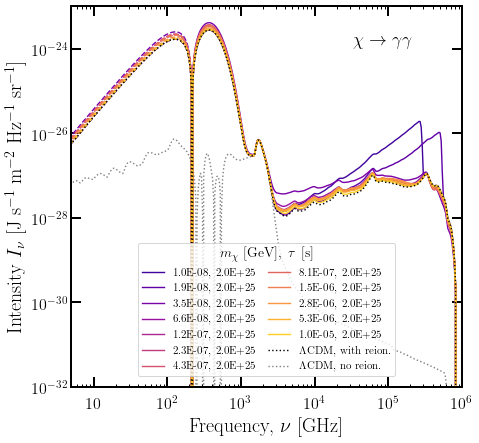

In [6]:
eng = data_list[0]['data'][-1]['distortion'].eng
hplanck = phys.hbar * 2 * np.pi
convert = phys.nB * eng * hplanck * phys.c /(4*np.pi) * phys.ele * 1e4
nu = eng/hplanck

plt.figure(figsize=(7, 7))
ax = plt.gca()
cmap = cm.plasma(np.linspace(0.1, 0.9, 12))

plt.loglog()
plt.xlim([5, 1e6])
plt.ylim([1e-32, 1e-23])
plt.xlabel(r'Frequency, $\nu$ [GHz]', fontsize=20)
plt.ylabel(
    r'Intensity $I_{\nu}$ '
    +'[J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]', 
    fontsize=20
)
plt.text(0.72, 0.9, r'$\chi \rightarrow \gamma\gamma$',
        fontsize = 18, transform = ax.transAxes)
                
for ii, data in enumerate(data_list):
    plt.plot(
        nu/1e9, convert * data['data'][-1]['distortion'].dNdE,
        color=cmap[ii], linestyle='solid', linewidth=1.4, 
        label=f"{data['DM_params']['mDM']/1e9:.1E}, {data['DM_params']['inj_param']:.1E}"
    )
    plt.plot(
        nu/1e9, -convert * data['data'][-1]['distortion'].dNdE,
        color=cmap[ii], linestyle='--', linewidth=1.4,
    )

plt.plot(
    nu/1e9, convert * no_DM['data'][-1]['distortion'].dNdE,
    color='k', linestyle=':', linewidth=1.4, label=r"$\Lambda$CDM, with reion."
)
plt.plot(
    nu/1e9, -convert * no_DM['data'][-1]['distortion'].dNdE,
    color='k', linestyle=':', linewidth=1.4
)
plt.plot(
    nu/1e9, convert * no_DM_no_reion['data'][-1]['distortion'].dNdE,
    color='gray', linestyle=':', linewidth=1.4, zorder=0, label=r"$\Lambda$CDM, no reion."
)
plt.plot(
    nu/1e9, -convert * no_DM_no_reion['data'][-1]['distortion'].dNdE,
    color='gray', linestyle=':', linewidth=1.4, zorder=0
)

plt.legend(title=r'$m_\chi$ [GeV], $\,\tau$ [s]', 
        loc='lower center', title_fontsize=14, framealpha=0.8, facecolor='white',
        fontsize=11, ncol=2, columnspacing=1)

# plt.savefig(fig_dir+'distortion_lowm.pdf')

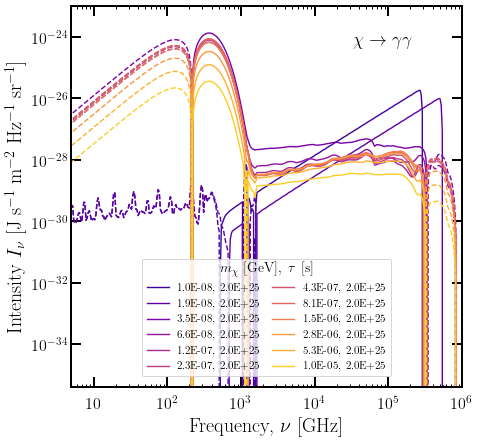

In [10]:
eng = data_list[0]['data'][-1]['distortion'].eng
hplanck = phys.hbar * 2 * np.pi
convert = phys.nB * eng * hplanck * phys.c /(4*np.pi) * phys.ele * 1e4
nu = eng/hplanck

plt.figure(figsize=(7, 7))
ax = plt.gca()
cmap = cm.plasma(np.linspace(0.1, 0.9, 12))

plt.loglog()
plt.xlim([5, 1e6])
plt.ylim([4e-36, 1e-23])
plt.xlabel(r'Frequency, $\nu$ [GHz]', fontsize=20)
plt.ylabel(
    r'Intensity $I_{\nu}$ '
    +'[J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]', 
    fontsize=20
)
plt.text(0.72, 0.9, r'$\chi \rightarrow \gamma\gamma$',
        fontsize = 18, transform = ax.transAxes)
                
for ii, data in enumerate(data_list):
    plt.plot(
        nu/1e9, convert * (data['data'][-1]['distortion'].dNdE - no_DM['data'][-1]['distortion'].dNdE),
        color=cmap[ii], linestyle='solid', linewidth=1.4, 
        label=f"{data['DM_params']['mDM']/1e9:.1E}, {data['DM_params']['inj_param']:.1E}"
    )
    plt.plot(
        nu/1e9, -convert * (data['data'][-1]['distortion'].dNdE - no_DM['data'][-1]['distortion'].dNdE),
        color=cmap[ii], linestyle='--', linewidth=1.4,
    )

plt.legend(title=r'$m_\chi$ [GeV], $\,\tau$ [s]', 
        loc='lower center', title_fontsize=14, framealpha=0.8, facecolor='white',
        fontsize=11, ncol=2, columnspacing=1)

# plt.savefig(fig_dir+'distortion_lowm.pdf')

# Ionization difference relative to RECFAST

In [12]:
# Get Recfast ionization history
rs_list = data_list[0]['data'][-1]['rs']
res_Recfast = tla.get_history(
    rs_list, high_rs=1.555e3, recfast_TLA=True,
    reion_switch=True, reion_method='Puchwein'
)

xe_Recfast = res_Recfast[:,1]

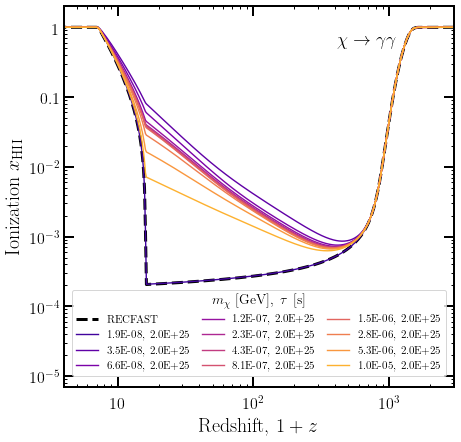

In [30]:
eng = data_list[0]['data'][-1]['distortion'].eng
hplanck = phys.hbar * 2 * np.pi
convert = phys.nB * eng * hplanck * phys.c /(4*np.pi) * phys.ele * 1e4
nu = eng/hplanck

plt.figure(figsize=(7, 7))
ax = plt.gca()
cmap = cm.plasma(np.linspace(0.1, 0.9, 12))

plt.loglog()
plt.xlim([4, 3000])
plt.ylim([7e-6, 2])
plt.xlabel(r'Redshift, $1+z$', fontsize=20)
plt.ylabel(
    r'Ionization $x_\mathrm{HII}$', 
    fontsize=20
)
plt.text(0.7, 0.9, r'$\chi \rightarrow \gamma\gamma$',
        fontsize = 18, transform = ax.transAxes)

plt.plot(
    rs_list, xe_Recfast, color='k', linestyle='--', linewidth=3, label="RECFAST"
)

for ii, data in enumerate(data_list[1:]):
    plt.plot(
        rs_list, data['data'][-1]['x'][:,0],
        color=cmap[ii], linestyle='solid', linewidth=1.4, 
        label=f"{data['DM_params']['mDM']/1e9:.1E}, {data['DM_params']['inj_param']:.1E}"
    )

plt.legend(title=r'$m_\chi$ [GeV], $\,\tau$ [s]', 
        loc='lower center', title_fontsize=14, framealpha=0.8, facecolor='white',
        fontsize=11, ncol=3, columnspacing=1)

plt.savefig(fig_dir+'xe_lowm.pdf')

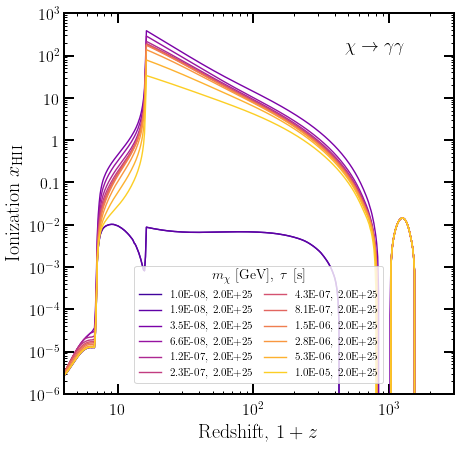

In [15]:
eng = data_list[0]['data'][-1]['distortion'].eng
hplanck = phys.hbar * 2 * np.pi
convert = phys.nB * eng * hplanck * phys.c /(4*np.pi) * phys.ele * 1e4
nu = eng/hplanck

plt.figure(figsize=(7, 7))
ax = plt.gca()
cmap = cm.plasma(np.linspace(0.1, 0.9, 12))

plt.loglog()
plt.xlim([4, 3000])
plt.ylim([1e-6, 1e3])
plt.xlabel(r'Redshift, $1+z$', fontsize=20)
plt.ylabel(
    r'Ionization $x_\mathrm{HII}$', 
    fontsize=20
)
plt.text(0.72, 0.9, r'$\chi \rightarrow \gamma\gamma$',
        fontsize = 18, transform = ax.transAxes)

for ii, data in enumerate(data_list):
    plt.plot(
        rs_list, (data['data'][-1]['x'][:,0] - xe_Recfast) / xe_Recfast,
        color=cmap[ii], linestyle='solid', linewidth=1.4, 
        label=f"{data['DM_params']['mDM']/1e9:.1E}, {data['DM_params']['inj_param']:.1E}"
    )

plt.legend(title=r'$m_\chi$ [GeV], $\,\tau$ [s]', 
        loc='lower center', title_fontsize=14, framealpha=0.8, facecolor='white',
        fontsize=11, ncol=2, columnspacing=1
)

# plt.savefig(fig_dir+'xe_grid.pdf')